In [1]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

v_bias = np.array([[50,50,50]]).T

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 6.8e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(pxscl_lamD)

/opt/conda/envs/km310gpu/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


19.200826816825295 arcsec
0.08235913638757239


In [5]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [3]:
npsf = 100
cam.set_roi(530, 900, npsf, client0)

In [4]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 1.


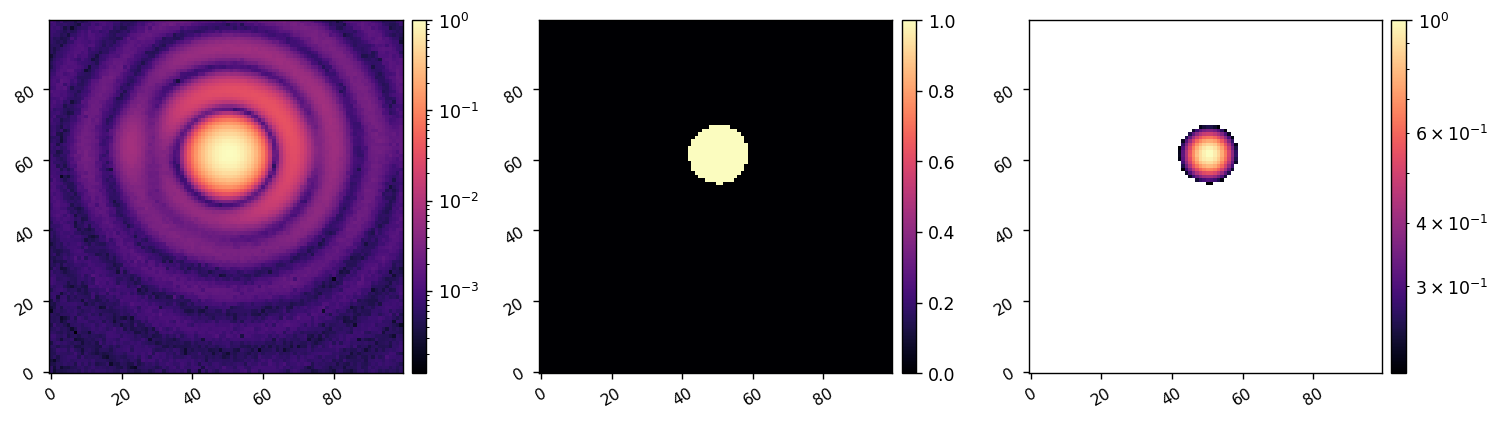

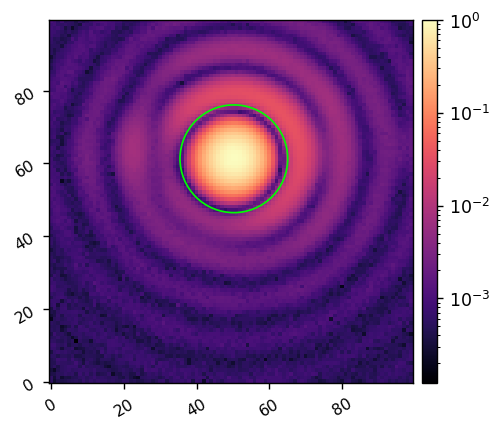

In [6]:
cam.Nframes = 1000
im = cam.snap()

reload(utils)
cen = utils.centroid(im, thresh=0.2, plot=True)
imshow1(im, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


In [17]:
fsm = ImageStream('fsm')
fsm.write(0*v_bias)

In [9]:
fsm.buffer

array([[50.],
       [50.],
       [50.]], dtype=float32)

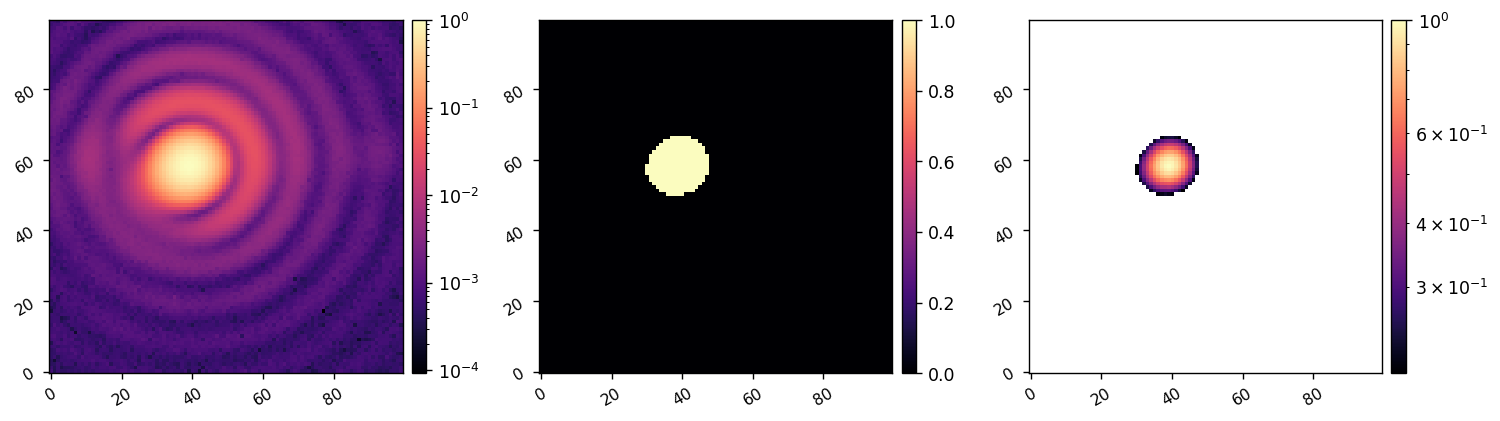

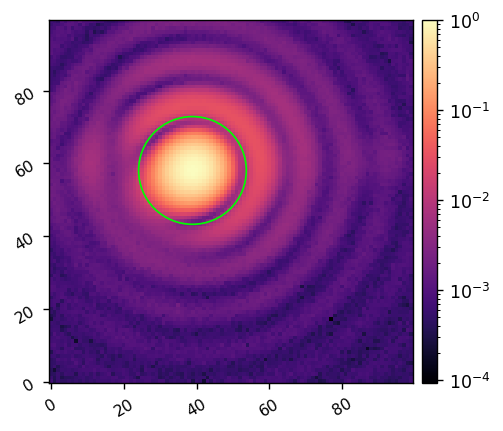

In [10]:
cam.Nframes = 5000
im_bias_1 = cam.snap()

reload(utils)
cen_1 = utils.centroid(im_bias_1, thresh=0.2, plot=True)
imshow1(im_bias_1, lognorm=True, patches=[Circle(cen_1, 1.22/pxscl_lamD, fill=False, color='lime')])


In [142]:
# time.sleep(2)
# fsm.write(np.array([[50,50,50]]).T)
reload(fsm_utils)
v_tt = fsm_utils.get_fsm_volts(tip=0*as_per_lamD, tilt=0.5*as_per_lamD)
fsm.write(v_tt)

Displacements: A = 5.00e-06 m, 5.28e-06 m, 4.72e-06 m. 
Delta Voltages: A = 50.00, B = 52.79, C = 47.21. 


In [128]:
fsm_utils.D_per_V

<Quantity 0.1 um>

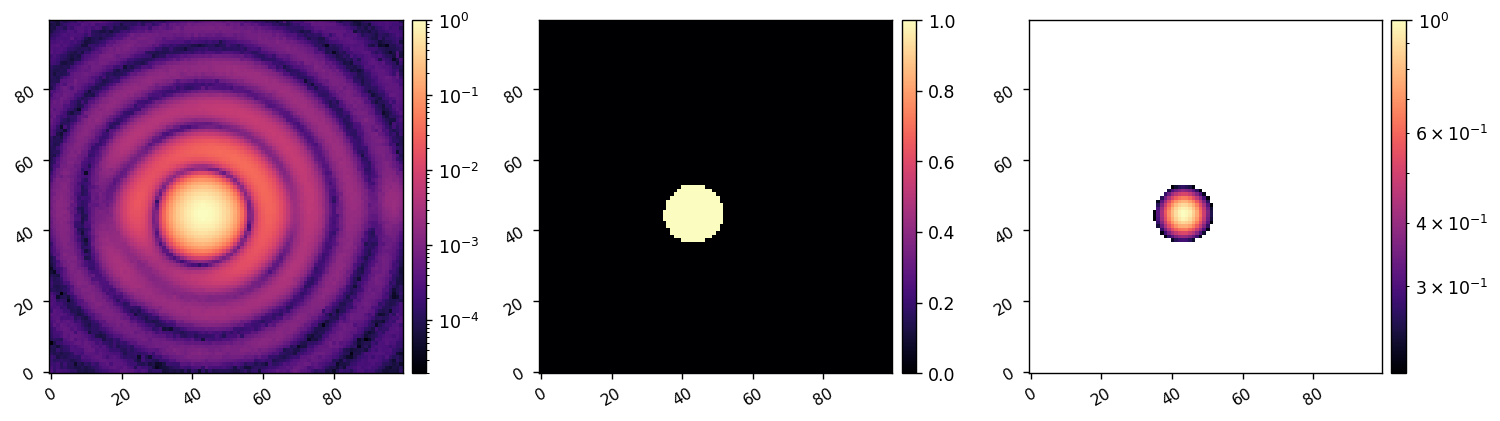

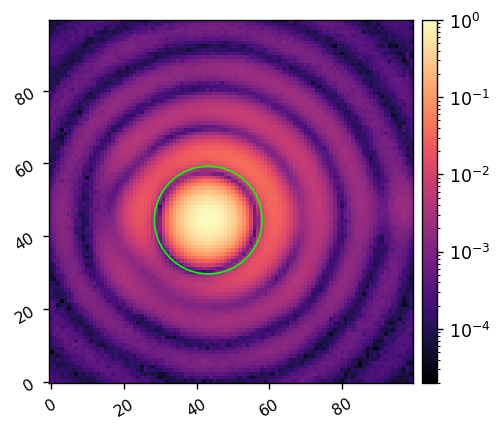

In [143]:

cam.Nframes = 5000
im_2 = cam.snap()

reload(utils)
cen_2 = utils.centroid(im_2, thresh=0.2, plot=True)
imshow1(im_2, lognorm=True, patches=[Circle(cen_2, 1.22/pxscl_lamD, fill=False, color='lime')])


In [144]:
cen_diff = cen_2 - cen_1
print(cen_diff)

shift_pix = np.sqrt(np.sum(np.square(cen_diff)))
shift_lamD = shift_pix * pxscl_lamD
shift_as = shift_lamD * as_per_lamD
print(shift_lamD)
print(shift_as)

[-4.01452007 -7.07944509]
0.6702784750124503
12.86990091775982 arcsec


In [9]:
fsm.write(0*v_bias)

In [66]:
v_tt = fsm_utils.get_fsm_volts(tip=0*as_per_lamD, tilt=2*as_per_lamD)
volts = [v_bias, v_tt]
freq = 2
try:
    print('Modulating FSM ...')
    i = 0
    while True:
        fsm.write(volts[i%2])
        i += 1 
        time.sleep(1/freq)
except KeyboardInterrupt:
    print('FSM modulation stopped!')
    fsm.write(v_bias)


Displacements: A = 5.64e-06 m, 4.68e-06 m, 4.68e-06 m. 
Delta Voltages: A = 56.45, B = 46.78, C = 46.78. 
Modulating FSM ...
FSM modulation stopped!


In [12]:
amp = 1*as_per_lamD

freq = 1*u.Hz
t_max = (1/freq).to(u.s)
Nsamps = 37
times = np.linspace(0, t_max, Nsamps)
delt = (times[1]-times[0]).to_value(u.s)

tip_wave = amp*np.sin(2*np.pi*freq.to_value(u.Hz)*times.to_value(u.s))/np.sqrt(2)
tilt_wave = amp*np.cos(2*np.pi*freq.to_value(u.Hz)*times.to_value(u.s))/np.sqrt(2)
volt_commands = np.zeros((Nsamps, 3, 1))
for i in range(Nsamps):
    volt_commands[i] = fsm_utils.get_fsm_volts(tip=tip_wave[i], tilt=tilt_wave[i])

Displacements: A = 5.00e-06 m, 5.39e-06 m, 4.61e-06 m. 
Delta Voltages: A = 50.00, B = 53.95, C = 46.05. 
Displacements: A = 5.08e-06 m, 5.35e-06 m, 4.57e-06 m. 
Delta Voltages: A = 50.79, B = 53.49, C = 45.71. 
Displacements: A = 5.16e-06 m, 5.29e-06 m, 4.55e-06 m. 
Delta Voltages: A = 51.56, B = 52.93, C = 45.51. 
Displacements: A = 5.23e-06 m, 5.23e-06 m, 4.54e-06 m. 
Delta Voltages: A = 52.28, B = 52.28, C = 45.44. 
Displacements: A = 5.29e-06 m, 5.16e-06 m, 4.55e-06 m. 
Delta Voltages: A = 52.93, B = 51.56, C = 45.51. 
Displacements: A = 5.35e-06 m, 5.08e-06 m, 4.57e-06 m. 
Delta Voltages: A = 53.49, B = 50.79, C = 45.71. 
Displacements: A = 5.39e-06 m, 5.00e-06 m, 4.61e-06 m. 
Delta Voltages: A = 53.95, B = 50.00, C = 46.05. 
Displacements: A = 5.43e-06 m, 4.92e-06 m, 4.65e-06 m. 
Delta Voltages: A = 54.29, B = 49.21, C = 46.51. 
Displacements: A = 5.45e-06 m, 4.84e-06 m, 4.71e-06 m. 
Delta Voltages: A = 54.49, B = 48.44, C = 47.07. 
Displacements: A = 5.46e-06 m, 4.77e-06 m, 4.7

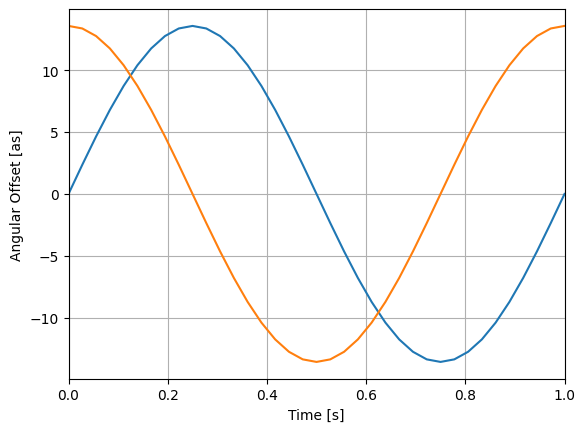

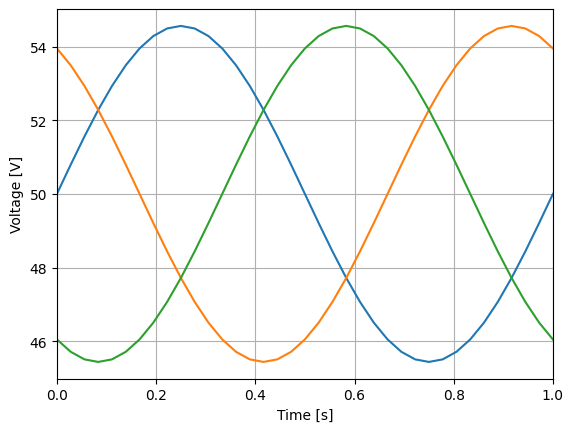

In [15]:
import matplotlib.pyplot as plt
plt.plot(times, tip_wave)
plt.plot(times, tilt_wave)
plt.xlim([0, t_max.to_value(u.s)])
plt.xlabel('Time [s]')
plt.ylabel('Angular Offset [as]')
plt.grid()
plt.show()

plt.plot(times, volt_commands[:,0])
plt.plot(times, volt_commands[:,1])
plt.plot(times, volt_commands[:,2])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.xlim([0, t_max.to_value(u.s)])
plt.grid()
plt.show()

In [16]:
freq = 1 * Nsamps
try:
    print('Modulating FSM ...')
    i = 0
    while i<Nsamps+1:
        if i==Nsamps:
            i = 0
        fsm.write(volt_commands[i])
        time.sleep(1/freq)
        i += 1
        # print(i)
except KeyboardInterrupt:
    print('FSM modulation stopped!')
    fsm.write(v_bias)

Modulating FSM ...
FSM modulation stopped!
